#### Module import & Load Data

In [1]:
# 메모리내 변수 제거

all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [50]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold

import wordcloud
import nltk
# import seaborn as sns
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
train1 = pd.read_csv('c:/data/project/train.csv')
test = pd.read_csv('c:/data/project/test.csv')

In [4]:
train = train1.copy()
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [5]:
train.drop(columns=['ID', 'first_party', 'second_party'], inplace=True)
# train.head()
# train['first_party_winner'].value_counts()

In [6]:
train_target = pd.DataFrame(train, columns=['first_party_winner'])
# train_target

In [7]:
train_nlp = train['facts']
train_nlp = pd.DataFrame(train_nlp, columns=['facts'])
train_nlp['facts'] = train_nlp['facts'].str.replace(r'<[^<>]*>', '', regex=True)
# train_nlp

#### 토큰화 확인

In [8]:
# corpus = train_nlp["facts"]
# lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
# 어절 별로 키워드 반환
# lst_tokens

### 불용어 사전 정의 (사용자 지정 & 기본 제공[english])

In [9]:
##### 불용어 처리 및 어간과 표제어 추출 함수 #####

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # 정규식, 치환 문자열, src 문자열 입력 -> 해당 문자가 발견되지 않는 경우 space bar로 변환, 단어별 split을 위한 작업
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [10]:
##### 단어와 빈도수 측정 및 시각화 함수 #####

def word_freq(data, columns, titleName=None, graph=False):
    corpus = data[columns]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

    dic_word_freq = nltk.FreqDist(lst_tokens)
    words_freq = pd.DataFrame(dic_word_freq.most_common(), columns=["Word","Freq"])

    if graph==True:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.suptitle('Most frequent words'+titleName, fontsize=15)
        figure(figsize=(30, 24))
        
        words_freq.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                  kind="barh", title="words", ax=ax, 
                  legend=False).grid(axis='x')
               
        ax.set(ylabel=None)
        plt.show()
    
    return [words_freq, dic_word_freq]

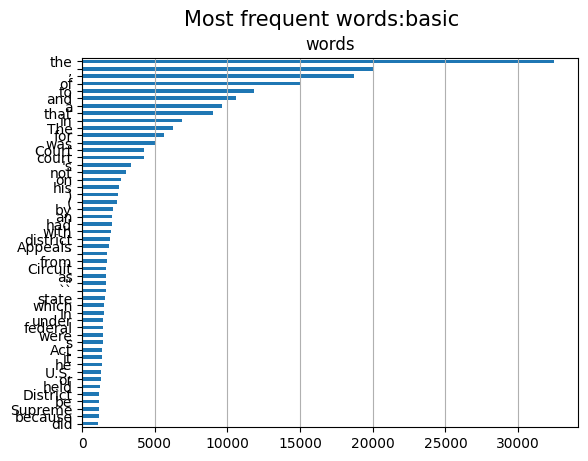

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,the,32500
1,",",20104
2,.,18697
3,of,15057
4,to,11798
...,...,...
21425,patentee,1
21426,localize,1
21427,spurious,1
21428,bar-coded,1


In [11]:
word_freq(train_nlp, 'facts', ':basic', True)[0]

##### 기본 불용어 처리

In [12]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# NLTK가 정의한 영어 불용어 리스트를 리턴

train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
# nltk 기본 불용어를 제거한 결과
train_nlp

,facts
0,june 27 1962 phil st amant candidate public of...
1,ramon nelson riding bike suffered lethal blow ...
2,alabama state court convicted billy joe magwoo...
3,victor linkletter convicted state court eviden...
4,april 24 1953 selma alabama intruder broke apa...
...,...
2473,congress amended clean air act energy policy a...
2474,alliance bond fund inc investment fund purchas...
2475,1992 district court sentenced manuel peguero 2...
2476,march 8 1996 enrico st cyr lawful permanent re...


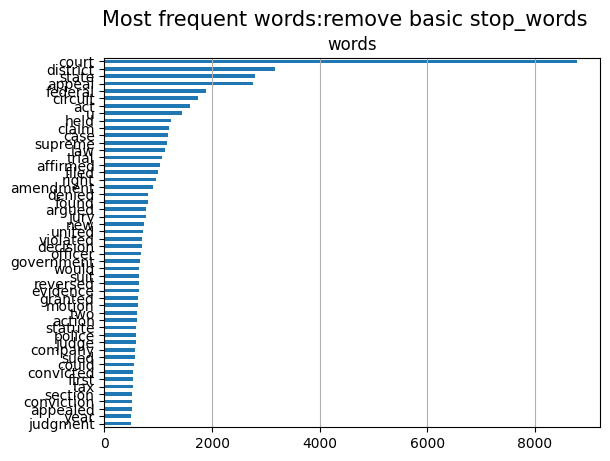

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,8776
1,district,3168
2,state,2793
3,appeal,2757
4,federal,1886
...,...,...
18013,patentee,1
18014,localize,1
18015,spurious,1
18016,barcoded,1


In [13]:
word_freq(train_nlp, 'facts', ':remove basic stop_words',True)[0]

##### 사용자 정의 불용어 사전 적용 - 빈도수가 1인 단어 리스트 및 판결에 필요 없는 단어 리스트 직접 지정

In [14]:
def user_stopwords(dic):
    stop_words=[]
    for word, freq in dic.most_common():
        if freq == 1:
            stop_words.append(word)
    return stop_words

In [15]:
dic_words_freq = word_freq(train_nlp, 'facts', False)[1]

stop_words=user_stopwords(dic_words_freq)
# stop_words

In [16]:
# user_stopwords = set(["appeal","filed","affirmed","held","u","state","supreme","federal","circuit","district", "law", "court", "case", "plaintiff", "defendant",
#                 "judge", "trial", "jurisdiction", "evidence", "witness", "proceeding",
#                 "litigation", "party", "motion", "action", "suit", "claim", "issue",
#                 "fact", "hearing", "judgment", "order", "allegation", "argument",
#                 "brief", "charge", "complaint", "contract", "crime", "decision", "defense",
#                 "document", "file", "find", "hold", "injunction", "instruction", "lawyer", "legal",
#                 "liability", "matter", "notice", "opinion", "plea", "point", "policy", "practice",
#                 "present", "prosecution", "record", "rule", "sentence", "statute", "testimony", "verdict",
#                 'james', 'bike', 'named',"section", "act", "article", "chapter", "provision", "paragraph"
#                 "amendment", "code", "regulation", "statutory", "subsection", "constitution", "legislation",
#                 "ordinance", "regulatory", "rulemaking", "title", "enactment", "resolution", "treaty",
#                 "administrative", "bylaw",  "legislative", "prescription", "ratification", "repeal",
#                 "statutorily", "adjudicate", "adjudication", "arbitrate", "arbitration", "conciliation",
#                 "decree", "litigate", "mediation", "remand", "tribunal", "appellate", "affirm", "overrule",
#                 "reversal", "vacate", "writ", "certiorari", "mandamus", "subpoena", "arraignment",
#                 "indictment", "misdemeanor", "probation", "restitution", "summons", "verdict", "acquittal",
#                 "bail", "contempt", "conviction", "felony", "parole", "sentence",
#                 "attorney", "barrister", "counsel", "juror", "litigator", "magistrate", "prosecutor",
#                 "solicitor", "stipulation", "testator", "trustee", "executor", "heir", "lease", "lessor",
#                 "lessee", "mortgagee", "mortgagor", "assignee", "assignor", "debtor", "creditor", "insurer",
#                 "insured", "beneficiary", "fiduciary", "principal", "agent"])

In [17]:
train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=stop_words))
train_nlp

,facts
0,june 27 1962 phil st amant candidate public of...
1,ramon nelson riding bike suffered lethal blow ...
2,alabama state court convicted billy joe magwoo...
3,victor linkletter convicted state court eviden...
4,april 24 1953 selma alabama intruder broke apa...
...,...
2473,congress amended clean air act energy policy a...
2474,alliance bond fund inc investment fund purchas...
2475,1992 district court sentenced manuel peguero 2...
2476,march 8 1996 st cyr lawful permanent resident ...


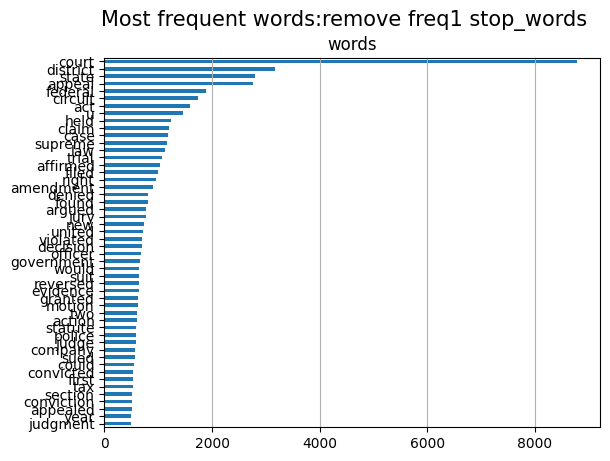

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,8776
1,district,3168
2,state,2793
3,appeal,2757
4,federal,1886
...,...,...
11264,drycleaning,2
11265,keyboard,2
11266,optical,2
11267,markmans,2


In [18]:
word_freq(train_nlp, 'facts', ':remove freq1 stop_words',True)[0]

#### 승소, 패소 시의 단어 빈도수 확인

###### 위의 전처리 과정에서 얻은 facts와 first_party_winner만 남긴 데이터 프레임을 train_nlp2로 지정함

In [19]:
train_nlp = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
train_nlp

,facts,first_party_winner
0,june 27 1962 phil st amant candidate public of...,1
1,ramon nelson riding bike suffered lethal blow ...,0
2,alabama state court convicted billy joe magwoo...,1
3,victor linkletter convicted state court eviden...,0
4,april 24 1953 selma alabama intruder broke apa...,1
...,...,...
2473,congress amended clean air act energy policy a...,1
2474,alliance bond fund inc investment fund purchas...,1
2475,1992 district court sentenced manuel peguero 2...,0
2476,march 8 1996 st cyr lawful permanent resident ...,0


##### 승소 시 단어 빈도 수 -> 빈도수가 1인 단어가 꽤 존재함 -> 이를 제거할지 고민해봐야함

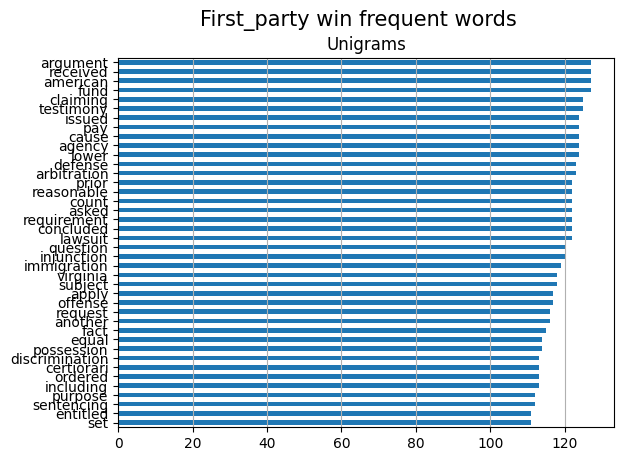

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,5943
1,district,2071
2,appeal,1856
3,state,1827
4,federal,1250
...,...,...
9942,succeeded,1
9943,tucson,1
9944,formulate,1
9945,elective,1


In [20]:
y=1
corpus1 = train_nlp[train_nlp["first_party_winner"]== y]["facts"]
first_tokens = nltk.tokenize.word_tokenize(corpus1.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("First_party win frequent words", fontsize=15)
figure(figsize=(30, 24))

first_words_freq = nltk.FreqDist(first_tokens)
dtf_uni1 = pd.DataFrame(first_words_freq.most_common(), columns=["Word","Freq"])
dtf_uni1.set_index("Word").iloc[200:240,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni1
# first_win_words = dtf_uni1['Word'][:50]

##### 패소 시 단어 빈도 수

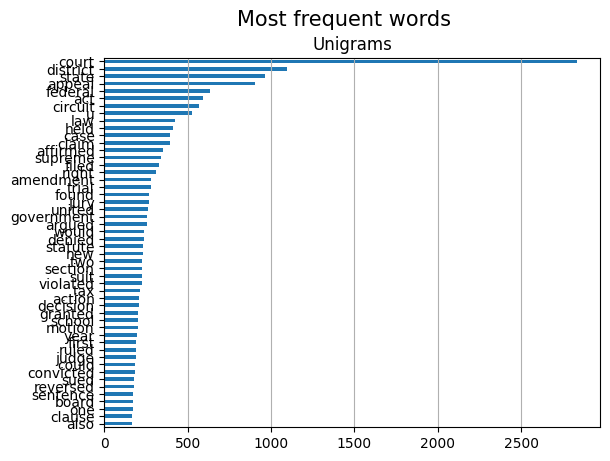

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,2833
1,district,1097
2,state,966
3,appeal,901
4,federal,636
...,...,...
7794,communicate,1
7795,ace,1
7796,lopezs,1
7797,274,1


In [21]:
y=0
corpus0 = train_nlp[train_nlp["first_party_winner"]== y]["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus0.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
figure(figsize=(30, 24))

dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni0 = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
dtf_uni0.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni0

In [22]:
# dtf_uni0[:50] == dtf_uni1[:50]

#### Wordcloud

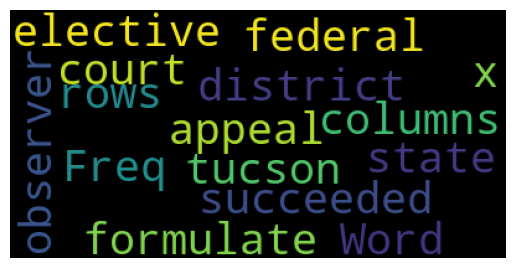

In [23]:
wc1 = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc1 = wc1.generate(str(dtf_uni1))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc1, cmap=None)
plt.show()

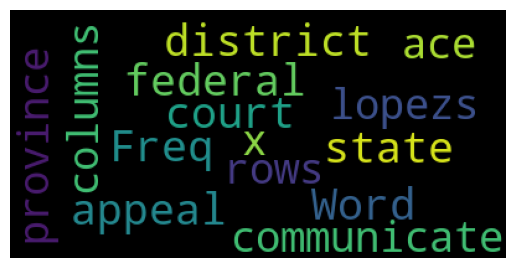

In [24]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc0 = wc0.generate(str(dtf_uni0))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

## Define Model & Train

In [25]:
train_nlp = pd.concat([train_nlp,train1['first_party'],train1['second_party']],axis=1, join='inner')
train_nlp



,facts,first_party_winner,first_party,second_party
0,june 27 1962 phil st amant candidate public of...,1,Phil A. St. Amant,Herman A. Thompson
1,ramon nelson riding bike suffered lethal blow ...,0,Stephen Duncan,Lawrence Owens
2,alabama state court convicted billy joe magwoo...,1,Billy Joe Magwood,"Tony Patterson, Warden, et al."
3,victor linkletter convicted state court eviden...,0,Linkletter,Walker
4,april 24 1953 selma alabama intruder broke apa...,1,William Earl Fikes,Alabama
...,...,...,...,...
2473,congress amended clean air act energy policy a...,1,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al."
2474,alliance bond fund inc investment fund purchas...,1,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc."
2475,1992 district court sentenced manuel peguero 2...,0,Peguero,United States
2476,march 8 1996 st cyr lawful permanent resident ...,0,Immigration and Naturalization Service,St. Cyr


In [26]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['facts'])
    X_party2 = vectorizer.transform(df['facts'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

X = get_vector(vectorizer, train_nlp, True)
ylabel = train_nlp["first_party_winner"]

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(X, ylabel, test_size=0.25, random_state=11)
X_train

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### LogisticRegression

In [37]:
# lr = LogisticRegression(solver='liblinear', class_weight = 'balanced')
# lr = LogisticRegression() # option 지정을 안 하니 성능이 더 좋아짐 -> accuracy : 0.643548, test 적용 시 1: 1124, 0: 116
# lr.fit(np.asarray(X_train), y_train)

LogisticRegression()

In [38]:
# print("LR Accuracy : %f" % lr.score(np.asarray(X_eval), y_eval)) # 검증 데이터로 성능 측정
# accuracy_score(y_eval, lr.predict(np.asarray(X_eval)))

LR Accuracy : 0.643548


0.6435483870967742

In [110]:
# test_lr = pd.DataFrame(lr.predict(np.asarray(X_eval)))
# test_lr.value_counts()

1    435
0    185
Name: count, dtype: int64

### XGBoost

In [25]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV, KFold

# xgb_param_grid={
#     'n_estimators' : [100,300,500],
#     'learning_rate' : [0.01,0.1],
#     'max_depth' : [3,5,7]
#     # 'gamma' : [0,1,2,3],
#     # 'colsample_bytree' : [0.7,0.8,0.9],  
#     # 'subsample' : [0, 0.5, 1],
#     # 'max_delta_step' : [1,3],
#     # 'eta' : [0.1, 0.3, 0.5, 0.7]
# }

# xgb = XGBClassifier(booster='gblinear',objective='binary:logistic',max_delta_step = 3)
# # cv=KFold(n_splits=3, shuffle=True, random_state=11)
# # cv=KFold(n_splits=3)
# xgb_grid=GridSearchCV(xgb, param_grid=xgb_param_grid, scoring='f1', cv=3, n_jobs=1)

# # xgb = XGBClassifier(
# #                       booster = 'gblinear',
# #                       scale_pos_weight=5,
# #                       learning_rate=0.01,  
# #                       colsample_bytree = 0.7,
# #                       subsample = 0.5,
# #                       max_delta_step = 3,
# #                       reg_lambda = 2,
# #                       objective='binary:logistic',
# #                       n_estimators=818, 
# #                       max_depth=6,
# #                      )

# xgb_grid.fit(X_train, y_train)

In [112]:
# xgb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}

In [113]:
# xgb = XGBClassifier(booster='gblinear',
#                     objective='binary:logistic',
#                     max_delta_step = 3,
#                     learning_rate=0.01,
#                     max_depth=5,
#                     n_estimators=500
#                     )

# xgb.fit(X_train, y_train)

[16:19:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_delta_step", "max_depth" } are not used.



XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=3,
              max_depth=5, max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [114]:
# y_pred = xgb.predict_proba(X_eval)
# y_pred

array([[1.1737615e-01, 8.8262385e-01],
       [1.3864517e-02, 9.8613548e-01],
       [9.4880617e-01, 5.1193822e-02],
       ...,
       [1.2617975e-01, 8.7382025e-01],
       [8.1129569e-01, 1.8870430e-01],
       [8.4400177e-05, 9.9991560e-01]], dtype=float32)

In [115]:
## grid search 적용 후
# print("XGB Accuracy : %f" % xgb.score(X_eval, y_eval)) # 검증 데이터로 성능 측정
# accuracy_score(y_eval, xgb.predict(X_eval))

XGB Accuracy : 0.574194


0.5741935483870968

In [116]:
# test_xgb = pd.DataFrame(xgb.predict(X_eval))
# test_xgb.value_counts()

1    460
0    160
Name: count, dtype: int64

### 최적 모델 결정하기

### Optuna를 이용한 최적 파라미터 찾기 - XGBoost

In [52]:
import optuna
from optuna import Trial, visualization
# from optuna.samplers import TPESampler
# from sklearn.metrics import mean_absolute_error

In [49]:
# def objective(trial,data=X,target=ylabel):
#     train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
#     param = {
#         'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
#         'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
#         'n_estimators': 10000,
#         'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
#         'random_state': trial.suggest_categorical('random_state', [2020]),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
#     }
#     model = XGBClassifier(**param)  
#     model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
#     preds = model.predict(test_x)
#     f1 = f1_score(test_y, preds)
#     return f1

In [48]:
# study_xgb = optuna.create_study(direction='maximize')
# study_xgb.optimize(objective(X, ylabel), n_trials=30)
# print('Number of finished trials:', len(study_xgb.trials))
# print('Best trial:', study_xgb.best_trial.params)

In [53]:
def objective(trial: optuna.Trial):
    """Define the objective function"""
    params = {
        'max_depth': trial.suggest_int('max_depth', 5, 16),
        'learning_rate': trial.suggest_loguniform('learning_rate', low=5e-5, high=0.01),
        'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_eval)

    # Evaluate predictions
    accuracy = accuracy_score(y_eval, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))
params = trial.params

[I 2023-06-19 16:41:47,154] A new study created in memory with name: no-name-52abc26b-5bea-4896-aa2f-38e3188ff23b
C:\Users\user\AppData\Local\Temp\ipykernel_10560\2419484244.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', low=5e-5, high=0.01),
C:\Users\user\AppData\Local\Temp\ipykernel_10560\2419484244.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\user\AppData\Local\Temp\ipykernel_10560\2419484244.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/opt

Number of finished trials: 100
Best trial:
  Value: 0.6661290322580645
  Params: 
    max_depth: 15
    learning_rate: 6.865375182685279e-05
    n_estimators: 2879
    min_child_weight: 2
    gamma: 0.0016940514546739227
    subsample: 0.24127612649886057
    colsample_bytree: 0.1839478851582463
    reg_alpha: 0.4788953552950138
    reg_lambda: 0.014244622719060716


In [2]:
# optuna.visualization.plot_param_importances(study) # 파라미터 중요도 확인 그래프
# optuna.visualization.plot_optimization_history(study) # 최적화 과정 시각화

### Test csv 적용

In [28]:
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [29]:
dfTest = pd.DataFrame(test['facts'])
dfTest['facts'] = dfTest['facts'].str.replace(r'<[^<>]*>', '', regex=True)
dfTest["facts"] = dfTest["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
dfTest = pd.concat([dfTest,test['first_party'],test['second_party']],axis=1, join='inner')
dfTest['first_party_winner'] = np.zeros(len(dfTest)).astype(int)
dfTest

,facts,first_party,second_party,first_party_winner
0,1984 bail reform act allowed federal court det...,Salerno,United States,0
1,lexecon inc defendant class action lawsuit 28 ...,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",0
2,2002 2003 fox television station broadcast bil...,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.",0
3,trial armed robbery federally insured saving l...,Harold Kaufman,United States,0
4,1993 magistrate judge issued warrant authorizi...,Berger,Hanlon,0
...,...,...,...,...
1235,according executive order 12807 signed preside...,"Haitian Centers Council, Inc., et al.","Chris Sale, Acting Commissioner, Immigration A...",0
1236,section 109a clean air act caa requires enviro...,Whitman,"American Trucking Associations, Inc.",0
1237,linda matteo john madigan created plan utilizi...,Linda A. Matteo and John J. Madigan,William G. Barr,0
1238,1972 north carolina board agriculture adopted ...,Washington State Apple Advertising Commission,Hunt,0


In [30]:
X_test = get_vector(vectorizer, dfTest, False)
y_test = dfTest["first_party_winner"]
X_test

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
y_pred_test = lr.predict((np.asarray(X_test)))
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])
predcsv.value_counts()

first_party_winner
1                     1124
0                      116
Name: count, dtype: int64

## Inference & Submission

In [32]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = predcsv
submit.to_csv('./sample_submission.csv', index=False)
print('Done')

Done
